# DepMap PRISM Data Wrangling

This notebook preprocesses the **DepMap PRISM secondary drug repurposing dataset** to produce a clean, deduplicated table of drug-cell line-IC50 values.  
The workflow includes:

1. **Config validation** – Ensure required file paths are set correctly in `config.yml`.  
2. **Data loading** – Import cell line metadata and drug dose–response parameters.  
3. **Deduplication** – Resolve duplicate cell line–drug pairs within each screen (`HTS002`, `MTS010`) by preferring the highest quality curve fit (`r²`) or falling back to reproducible random selection.  
4. **Screen merging** – Combine both screens, prioritizing `MTS010` where overlaps occur.  
5. **QC checks** – Confirm no duplicate (cell line, drug) pairs remain.  
6. **Summary statistics and visualization** – Tabulate and plot dataset composition by tissue and cell line.  
7. **Export** – Save the cleaned dataset for downstream analysis.  

The output represents the **preferred IC50 values per unique (cell line, drug) combination**, ready to be used in downsteam agentic system experiments.


In [1]:
import pathlib
import yaml
import json

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jsonschema import Draft7Validator

from nbutils.pathing import project_file, repo_root
from nbutils.utils import IN_NOTEBOOK

if IN_NOTEBOOK:
    print("Running in IPython shell")
else:
    print("Running in standard Python shell")

Running in IPython shell


### Config Validation

In [2]:
# --- Step 1: Locate config file ---
# works only when vscode settings configuring 
# "jupyter.notebookFileRoot": "${workspaceFolder}" 
config_path = project_file("config.yml")
schema_path = project_file("config.schema.json")

if not config_path.exists():
    raise FileNotFoundError(f"Config file not found at: {config_path}")
if not schema_path.exists():
    raise FileNotFoundError(f"Schema file not found at: {schema_path}")

# --- Step 2: Load config.yml and schema ---
with open(config_path, "r") as f:
    config = yaml.safe_load(f)

with open(schema_path, "r") as f:
    schema = json.load(f)

# --- Step 3: Validate data section ---
validator = Draft7Validator(schema)
schema_errors = sorted(validator.iter_errors(config), key=lambda e: e.path)

if schema_errors:
    msg_lines = ["Config schema validation failed:"]
    for err in schema_errors:
        loc = "/".join(str(p) for p in err.path) or "<root>"
        msg_lines.append(f"- at `{loc}`: {err.message}")
    raise ValueError("\n".join(msg_lines))

# --- Step 4: Collect resolved paths ---
data_cfg = config["data"]

# Build resolved paths
base_dir = pathlib.Path(data_cfg["depmap_prism"])
paths = {
    "depmap_prism": base_dir,
    "cell_line_info": base_dir / data_cfg["cell_line_info"],
    "dose_response": base_dir / data_cfg["dose_response"],
}

rows, errors = [], []
for k, p in paths.items():
    status = "Exists" if p.exists() else "Not found"
    rows.append((k, str(p.resolve()), status))
    if status != "Exists":
        if k == "depmap_prism":
            errors.append(f"Directory missing: {p}")
        else:
            errors.append(f"File missing for '{k}': {p}")

# --- Step 5: Display summary nicely ---
config_df = pd.DataFrame(rows, columns=["Config Key", "Resolved Path", "Status"]).set_index("Config Key")
print(config_df)

# --- Step 6: Fail if any errors were collected ---
if errors:
    raise FileNotFoundError(
        "Config validation failed:\n" + "\n".join(f"- {e}" for e in errors) +
        "\nPlease refer to /config.yml.template for correct specification."
    )

                                                    Resolved Path  Status
Config Key                                                               
depmap_prism                           /mnt/data_nvme1/data/PRISM  Exists
cell_line_info  /mnt/data_nvme1/data/PRISM/secondary-screen-ce...  Exists
dose_response   /mnt/data_nvme1/data/PRISM/secondary-screen-do...  Exists


## Preprocessing

### Load depmap PRISM cell line and drug dose response 

In [3]:
cell_line_info_df = pd.read_csv(
    config_df.loc['cell_line_info', 'Resolved Path'])
print(cell_line_info_df.head())

     row_name   depmap_id              ccle_name primary_tissue  \
0  ACH-000824  ACH-000824     KYSE510_OESOPHAGUS      esophagus   
1  ACH-000954  ACH-000954      HEC1A_ENDOMETRIUM         uterus   
2  ACH-000601  ACH-000601      MIAPACA2_PANCREAS       pancreas   
3  ACH-000651  ACH-000651  SW620_LARGE_INTESTINE     colorectal   
4  ACH-000361  ACH-000361           SKHEP1_LIVER          liver   

     secondary_tissue tertiary_tissue passed_str_profiling  
0  esophagus_squamous             NaN                 True  
1  uterus_endometrium             NaN                 True  
2                 NaN             NaN                 True  
3                 NaN             NaN                 True  
4                 NaN             NaN                 True  


In [4]:
dose_response_df = pd.read_csv(config_df.loc['dose_response', 'Resolved Path'])
print(dose_response_df.head())

                 broad_id   depmap_id           ccle_name screen_id  \
0  BRD-K71847383-001-12-5  ACH-000879  MFE296_ENDOMETRIUM    HTS002   
1  BRD-K71847383-001-12-5  ACH-000320       PSN1_PANCREAS    HTS002   
2  BRD-K71847383-001-12-5  ACH-001145         OC316_OVARY    HTS002   
3  BRD-K71847383-001-12-5  ACH-000873  KYSE270_OESOPHAGUS    HTS002   
4  BRD-K71847383-001-12-5  ACH-000855  KYSE150_OESOPHAGUS    HTS002   

   upper_limit  lower_limit     slope        r2       auc          ec50  ic50  \
0            1     2.122352 -0.022826 -0.026964  1.677789  8.415093e+06   NaN   
1            1     1.325174 -0.237504 -0.147274  1.240300  9.643742e+00   NaN   
2            1     2.089350 -0.302937  0.193893  1.472333  2.776687e-02   NaN   
3            1     1.311820 -0.209393 -0.005460  1.207160  2.654701e+00   NaN   
4            1     1.369799 -0.277530  0.132818  1.229332  5.889041e-01   NaN   

         name                                 moa                    target  \
0  cyta

/tmp/ipykernel_2608393/2948507465.py:1: DtypeWarning: Columns (14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  dose_response_df = pd.read_csv(config_df.loc['dose_response', 'Resolved Path'])


### Perform deduplication and merge

The secondary PRISM repurposing dataset includes two screens: `HTS002` and `MTS010`.  
Both contain overlapping **cell line–drug combinations**, and according to the official PRISM documentation (https://ndownloader.figshare.com/files/20238123), results from `MTS010` should be preferred when available.  

The documentation also states that both `'ccle_name'` and `'depmap_id'` can be used to identify cell lines. To ensure robustness, we include both identifiers in all grouping operations.  

An additional complication arises because `HTS002` contains duplicate cell line–drug entries that are only uniquely distinguishable when including the `broad_id` (batch–drug identifier). To avoid multiple IC50 values for the same combination—which would create ambiguity and downstream issues for agentic systems—we perform **per-screen deduplication** before merging.  

Deduplication is carried out as follows:
- Within each screen, group by `(smiles, depmap_id, ccle_name)`.
- If multiple entries exist for a group:
  - Prefer the row with the highest dose–response curve fit quality (`r²` value), if available.  
  - Otherwise, select a single row at random, using a fixed seed for reproducibility.  
- `smiles` is treated as the unique identifier for each drug.  

Finally, the deduplicated screens are combined, giving **priority to `MTS010`**: if the same cell line–drug pair exists in both screens, the `MTS010` entry is retained.


In [5]:
DEDUP_SEED = 42
CELL_DRUG_COMBO_KEYS = ["smiles","depmap_id","ccle_name"]

# --- Step 0: Keep the two screens of interest; basic QC ---
df = dose_response_df.query("screen_id in ['HTS002','MTS010']").copy()
df = df.dropna(subset=CELL_DRUG_COMBO_KEYS + ["ic50"])  # ensure keys exist
df["smiles"] = df["smiles"].astype(str).str.strip() # these identify unique drug

if "convergence" in df.columns:
    df = df[df["convergence"].eq(True)]

# --- Step 1: Deduplicate MTS010 by (smiles, cell line) ---
mts = df[df["screen_id"] == "MTS010"].copy()
if "r2" in mts.columns:
    # If multiple rows per (SMILES, cell line) and r^2 is available,
    # pick the highest-r^2 row per (SMILES, cell line)
    # prefer the better dose-reponse curve fit
    idx_mts = mts.groupby(CELL_DRUG_COMBO_KEYS)["r2"].idxmax()
    print(
        f"Deduplicating MTS010 via highest r^2: picked {len(idx_mts)} "
        f"rows from {len(mts)} total")
    mts_dedup = mts.loc[idx_mts]
else:
    # No r^2 -> pick one random row per (SMILES, cell line)
    # seed ensures reproducibility
    mts_dedup = mts.groupby(
        CELL_DRUG_COMBO_KEYS, 
        group_keys=False).sample(n=1, random_state=DEDUP_SEED)
    print(f"Deduplicating MTS010: picked {len(mts_dedup)} "
          f"rows from {len(mts)} total")

# --- Step 2: Deduplicate HTS002 by (smiles, cell line) ---
hts = df[df["screen_id"] == "HTS002"].copy()
if "r2" in hts.columns and hts["r2"].notna().any():
    # similarly,
    # pick the highest-r^2 row per (SMILES, cell line) if available
    idx_hts = hts.groupby(CELL_DRUG_COMBO_KEYS)["r2"].idxmax()
    print(f"Deduplicating HTS002 via highest r^2: picked {len(idx_hts)} "
          f"rows from {len(hts)} total")
    hts_dedup = hts.loc[idx_hts]
else:
    # same fallback: pick one random row per (SMILES, cell line)
    hts_dedup = hts.groupby(
        CELL_DRUG_COMBO_KEYS,
        group_keys=False).sample(n=1, random_state=DEDUP_SEED)
    print(f"Deduplicating HTS002: picked {len(hts_dedup)} "
          f"rows from {len(hts)} total")

# --- Step 3: Combine with MTS010 preference ---
combined = pd.concat([mts_dedup, hts_dedup], ignore_index=True, copy=False)
combined = combined.drop_duplicates(
    subset=["smiles","depmap_id","ccle_name"], keep="first").copy()

# --- Step 4: attach tissue etc. without row blow-up if (many:1)---
cli = (cell_line_info_df[["depmap_id","ccle_name","primary_tissue"]]
         .drop_duplicates(subset=["depmap_id","ccle_name"]))
combined = combined.merge(
    cli, on=["depmap_id","ccle_name"], how="left", validate="m:1")

print(combined.head())

Deduplicating MTS010 via highest r^2: picked 19909 rows from 19909 total
Deduplicating HTS002 via highest r^2: picked 317163 rows from 317636 total
                 broad_id   depmap_id             ccle_name screen_id  \
0  BRD-K31698212-001-02-9  ACH-000012           HCC827_LUNG    MTS010   
1  BRD-K31698212-001-02-9  ACH-000026  253JBV_URINARY_TRACT    MTS010   
2  BRD-K31698212-001-02-9  ACH-000030             PC14_LUNG    MTS010   
3  BRD-K31698212-001-02-9  ACH-000046           ACHN_KIDNEY    MTS010   
4  BRD-K31698212-001-02-9  ACH-000047          GCIY_STOMACH    MTS010   

   upper_limit  lower_limit     slope        r2       auc      ec50  ...  \
0            1     0.178760  1.963603  0.884767  0.546318  0.046950  ...   
1            1     0.454756  1.174343  0.504446  0.778797  0.196496  ...   
2            1     0.197965  0.661509  0.635062  0.796028  1.162465  ...   
3            1     0.467947  3.732989  0.664784  0.843652  0.577415  ...   
4            1     0.125498  0.84

### Confirm no duplicate cell-drug combinations

In [6]:
duplicates = combined.duplicated(subset=['ccle_name', 'name'], keep=False)
duplicate_counts = combined[duplicates].groupby(['ccle_name', 'name']).size().\
    reset_index(name='count')
duplicate_counts = duplicate_counts[duplicate_counts['count'] > 1]

if not duplicate_counts.empty:
    raise ValueError(
        f"Found {len(duplicate_counts)} duplicate (cell line, drug) "
        f"pairs:\n{duplicate_counts}"
    )

## Tabulate/visualize data

### primary tissue - cell line count

In [7]:
grouped_counts = combined.groupby(['primary_tissue', 'ccle_name']).size().\
    reset_index(name='count')
print(grouped_counts.head(20))

   primary_tissue              ccle_name  count
0       bile_duct   HUCCT1_BILIARY_TRACT    778
1       bile_duct    HUH28_BILIARY_TRACT    643
2       bile_duct  SNU1079_BILIARY_TRACT    544
3       bile_duct  SNU1196_BILIARY_TRACT    652
4       bile_duct   SNU245_BILIARY_TRACT    413
5       bile_duct   SNU308_BILIARY_TRACT    563
6       bile_duct   SNU869_BILIARY_TRACT    621
7            bone              A673_BONE    629
8            bone           CADOES1_BONE    555
9            bone             CAL78_BONE    557
10           bone            EWS502_BONE    690
11           bone   G292CLONEA141B1_BONE    454
12           bone               HOS_BONE    761
13           bone              MG63_BONE    851
14           bone            MHHES1_BONE    636
15           bone             SJSA1_BONE    517
16           bone             SKES1_BONE    730
17           bone            SW1353_BONE    512
18           bone              U2OS_BONE    611
19         breast           BT474_BREAST

### number of cell-drug combiantions in dataset, grouped by primary tissue

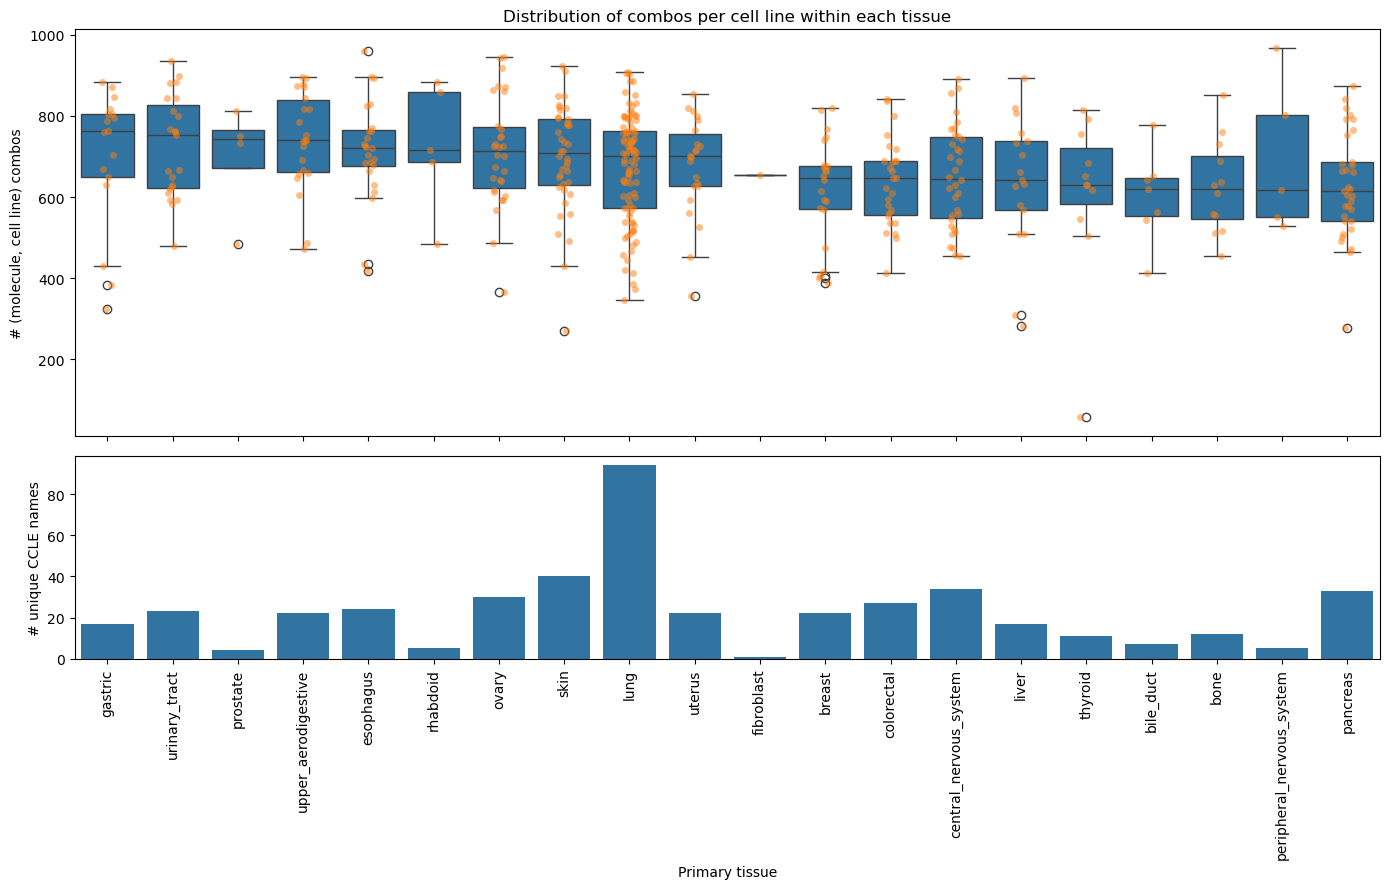

Saved figure to: /home/weishanli/Waylab/PRISM_Agent_LITL_experiments/output/figures/depmap_prism_tissue_summary.png


In [8]:
unique_counts = grouped_counts.groupby('primary_tissue')[
    'ccle_name'].nunique().reset_index(name='unique_ccle_count')

# grouped_counts: columns = ['primary_tissue', 'ccle_name', 'count']
# unique_counts:  columns = ['primary_tissue', 'unique_ccle_count']

# 1) Pick a consistent tissue order
order = (grouped_counts.groupby('primary_tissue')['count']
        .median().sort_values(ascending=False).index)

# limit to top-N tissues to keep the x-axis readable
TOP_N = 20
if TOP_N is not None:
    keep = list(order[:TOP_N])
    grouped_counts = grouped_counts[
        grouped_counts['primary_tissue'].isin(keep)]
    unique_counts  = unique_counts[
        unique_counts['primary_tissue'].isin(keep)]
    order = [t for t in order if t in keep]

# Ensure the bottom bar data follows the same order
unique_counts = unique_counts.set_index('primary_tissue').reindex(order).\
    reset_index()

# 2) Make vertically stacked subplots with a shared x-axis
fig, (ax_top, ax_bot) = plt.subplots(
    2, 1, figsize=(14, 9), sharex=True,
    gridspec_kw={'height_ratios': [2, 1]}
)

# --- Top: distribution per tissue (box + dots) ---
sns.boxplot(
    data=grouped_counts, 
    x='primary_tissue', 
    y='count', 
    order=order, 
    ax=ax_top)
sns.stripplot(data=grouped_counts, x='primary_tissue', y='count',
            order=order, ax=ax_top, jitter=True, alpha=0.5)
ax_top.set_xlabel('')
ax_top.set_ylabel('# (molecule, cell line) combos')
ax_top.set_title('Distribution of combos per cell line within each tissue')

# --- Bottom: number of unique cell lines per tissue (bar) ---
sns.barplot(data=unique_counts, x='primary_tissue', y='unique_ccle_count',
            order=order, ax=ax_bot)
ax_bot.set_xlabel('Primary tissue')
ax_bot.set_ylabel('# unique CCLE names')

# Rotate x labels only on the bottom axis
for label in ax_bot.get_xticklabels():
    label.set_rotation(90)

if IN_NOTEBOOK:

    plt.tight_layout()
    plt.show()
    
else:

    print("Not in a notebook environment. Skipping plot display")

# save to output/figures
out_dir = repo_root() / "output" / "figures"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "depmap_prism_tissue_summary.png"
fig.savefig(out_path, dpi=300, bbox_inches='tight')
print(f"Saved figure to: {out_path}")

plt.close(fig)

## Export preprocessed data

In [9]:
# output to the /data/processed directory
# only works as intended with vscode setting 
# "jupyter.notebookFileRoot": "${workspaceFolder}"
output_path = repo_root() \
    / "data" / "processed" / "processed_depmap_prism_ic50.csv"
output_path.parent.mkdir(parents=True, exist_ok=True)
combined.to_csv(output_path, index=False)